# Water, water everywhere! 

##  A brief look at the effects of evaporation on global climate

____________
<a id='section1'></a>

## 1. Imagine a world with reduced efficiency of evaporation
____________

Recall from the lecture on [surface energy balance](surface-energy-balance.ipynb) that the bulk formula for surface evaporation (latent heat flux) is 

$$ \text{LE} = L ~\rho ~ C_D ~ U \left( q_s - q_a \right) $$

which we approximated in terms of temperatures for a wet surface as

$$ \text{LE} \approx L ~\rho ~ C_D ~ U \left( (1-r) ~ q_s^* + r \frac{\partial q^*}{\partial T} \left( T_s - T_a \right) \right)  $$

The drag coefficient $C_D$ determines the flux for a given set of temperatures, relative humidity, and wind speed.

Now suppose that the drag coefficient is **reduced by a factor of two** (for evaporation only, not for sensible heat flux). i.e. *all else being equal, there will be half as much evaporation*.

Reasoning through the effects of this perturbation (and calculating the effects in models) will give us some insight into several different roles played by water in the climate system.

### Exercise:

**What is the effect of the reduced evaporation efficiency on surface temperature?**

- Formulate a hypothesis about how and why the surface temperature will change when $C_D$ is reduced by a factor of 2.
- Draw a sketch of the **surface temperature anomaly** as a function of latitude.

____________
<a id='section2'></a>

## 2. Reduced evaporation experiment in a simple model with `climlab`
____________


We can use `climlab` to construct a model for the zonal-average climate. The model will be on a pressure-latitude grid. It will include the following processes:

- **Seasonally varying insolation** as function of latitude
- RRTMG radiation, including water vapor dependence and prescribed clouds
- Fixed relative humidity
- Shortave absorption by ozone
- Meridional heat transport, implemented as a **horizontal down-gradient temperature diffusion** at every vertical level
- Sensible and Latent heat fluxes at the surface using the bulk formulas
- Convective adjustment of the **atmospheric** lapse rate (not surface)

This model basically draws together all the process models we have developed throughout the course, and adds the surface flux parameterizations.

Note that since we are using explicit surface flux parameterizations, we will now use the convective adjustment only on the **atmospheric** air temperatures. Previous our adjustment has also modified the **surface** temperature, which was implicitly taking account of the turbulent heat fluxes. 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import climlab
from climlab import constants as const

/opt/anaconda3/lib/python3.9/site-packages/climlab/radiation/cam3/cam3.py:60: UserWarning: Cannot import and initialize compiled Fortran extension, CAM3 module will not be functional.
  warnings.warn('Cannot import and initialize compiled Fortran extension, CAM3 module will not be functional.')


In [2]:
def inferred_heat_transport( energy_in, lat_deg ):
    '''Returns the inferred heat transport (in PW) by integrating the net energy imbalance from pole to pole.'''
    from scipy import integrate
    from climlab import constants as const
    lat_rad = np.deg2rad( lat_deg )
    return ( 1E-15 * 2 * np.math.pi * const.a**2 * 
            integrate.cumtrapz( np.cos(lat_rad)*energy_in,
            x=lat_rad, initial=0. ) )

In [3]:
# A two-dimensional domain
num_lev = 50
state = climlab.column_state(num_lev=num_lev, num_lat=60, water_depth=10.)
lev = state.Tatm.domain.axes['lev'].points

Here we specify cloud properties. The combination of the two cloud layers defined below were found to reproduce the **global, annual mean energy balance** in a single-column model.

We will specify the same clouds everywhere for simplicity. A more thorough investigation would incorporate some meridional variations in cloud properties.

In [4]:
#  Define two types of cloud, high and low
cldfrac = np.zeros_like(state.Tatm)
r_liq = np.zeros_like(state.Tatm)
r_ice = np.zeros_like(state.Tatm)
clwp = np.zeros_like(state.Tatm)
ciwp = np.zeros_like(state.Tatm)
#   indices
high = 10  # corresponds to 210 hPa
low = 40   #  corresponds to 810 hPa
#  A high, thin ice layer (cirrus cloud)
r_ice[:,high] = 14. # Cloud ice crystal effective radius (microns)
ciwp[:,high] = 10.  # in-cloud ice water path (g/m2)
cldfrac[:,high] = 0.322
#  A low, thick, water cloud layer (stratus)
r_liq[:,low] = 14.  # Cloud water drop effective radius (microns)
clwp[:,low] = 100.  # in-cloud liquid water path (g/m2)
cldfrac[:,low] = 0.21
# wrap everything up in a dictionary
mycloud = {'cldfrac': cldfrac,
          'ciwp': ciwp,
          'clwp': clwp,
          'r_ice': r_ice,
          'r_liq': r_liq}

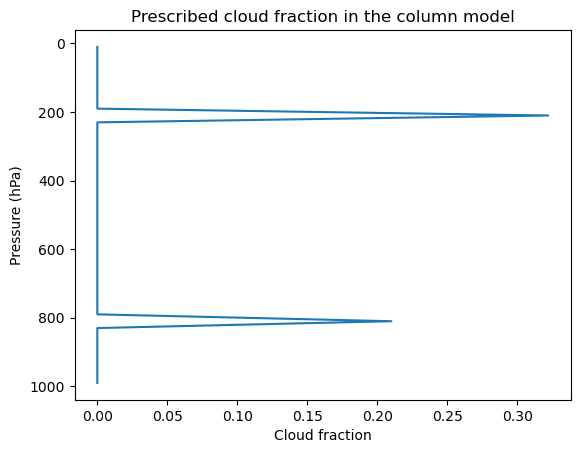

In [5]:
plt.plot(cldfrac[0,:], lev)
plt.gca().invert_yaxis()
plt.ylabel('Pressure (hPa)')
plt.xlabel('Cloud fraction')
plt.title('Prescribed cloud fraction in the column model')
plt.show()

In [6]:
#  The top-level model
model = climlab.TimeDependentProcess(state=state, name='Radiative-Convective-Diffusive Model')
#  Specified relative humidity distribution
h2o = climlab.radiation.ManabeWaterVapor(state=state)
#  Hard convective adjustment for ATMOSPHERE ONLY (not surface)
conv = climlab.convection.ConvectiveAdjustment(state={'Tatm':model.state['Tatm']},
                                               adj_lapse_rate=6.5,
                                               **model.param)
#  Annual mean insolation as a function of latitude and time of year
sun = climlab.radiation.DailyInsolation(domains=model.Ts.domain)
#  Couple the radiation to insolation and water vapor processes
rad = climlab.radiation.RRTMG(state=state, 
                              specific_humidity=h2o.q, 
                              albedo=0.125,
                              insolation=sun.insolation,
                              coszen=sun.coszen,
                              **mycloud)
model.add_subprocess('Radiation', rad)
model.add_subprocess('Insolation', sun)
model.add_subprocess('WaterVapor', h2o)
model.add_subprocess('Convection', conv)

model

/opt/anaconda3/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/opt/anaconda3/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/opt/anaconda3/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/opt/anaconda3/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. 

Here we add a diffusive heat transport process. The `climlab` code is set up to handle meridional diffusion level-by-level with a constant coefficient.

In [7]:
from climlab.dynamics import MeridionalDiffusion

# thermal diffusivity in W/m**2/degC
D = 0.04
# meridional diffusivity in m**2/s
K = D / model.Tatm.domain.heat_capacity[0] * const.a**2
d = MeridionalDiffusion(state={'Tatm': model.state['Tatm']}, 
                        K=K, **model.param)
model.add_subprocess('Diffusion', d)

Now we will add the surface heat flux processes. We have not used these before.

Note that the drag coefficient $C_D$ is passed as an input argument when we create the process. It is also stored as an attribute of the process and can be modified (see below).

The bulk formulas depend on a wind speed $U$. In this model, $U$ is specified as a constant. In a model with more complete dynamics, $U$ would be interactively calculated from the equations of motion.

In [8]:
#  Add surface heat fluxes
shf = climlab.surface.SensibleHeatFlux(state=model.state, Cd=0.5E-3)
lhf = climlab.surface.LatentHeatFlux(state=model.state, Cd=0.5E-3)
# set the water vapor input field for LHF
lhf.q = h2o.q
model.add_subprocess('SHF', shf)
model.add_subprocess('LHF', lhf)

### The complete model, ready to use!

In [9]:
print( model)

climlab Process of type <class 'climlab.process.time_dependent_process.TimeDependentProcess'>. 
State variables and domain shapes: 
  Ts: (60, 1) 
  Tatm: (60, 50) 
The subprocess tree: 
Radiative-Convective-Diffusive Model: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
   Radiation: <class 'climlab.radiation.rrtm.rrtmg.RRTMG'>
      SW: <class 'climlab.radiation.rrtm.rrtmg_sw.RRTMG_SW'>
      LW: <class 'climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW'>
   Insolation: <class 'climlab.radiation.insolation.DailyInsolation'>
   WaterVapor: <class 'climlab.radiation.water_vapor.ManabeWaterVapor'>
   Convection: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   Diffusion: <class 'climlab.dynamics.meridional_advection_diffusion.MeridionalDiffusion'>
   SHF: <class 'climlab.surface.turbulent.SensibleHeatFlux'>
   LHF: <class 'climlab.surface.turbulent.LatentHeatFlux'>



<div class="alert alert-warning">
Although this is a "simple" model, it has a 60 x 30 point grid and is **by far the most complex model** we have built so far in these notes. These runs will probably take 15 minutes or more to execute, depending on the speed of your computer.
</div>

In [10]:
model.integrate_years(4.)

Integrating for 1460 steps, 1460.9688 days, or 4.0 years.
Total elapsed time is 3.997347513512951 years.


In [11]:
#  One more year to get annual-mean diagnostics
model.integrate_years(1.)

Integrating for 365 steps, 365.2422 days, or 1.0 years.
Total elapsed time is 4.996684391891189 years.


In [12]:
ticks = [-90, -60, -30, 0, 30, 60, 90]
def make_nice_plot(fig,ax,cax):
    
    ax[0,0].set_title('Surface temperature')
    ax[0,0].set_ylabel('K')
    
    ax[0,1].invert_yaxis()
    fig.colorbar(cax, ax=ax[0,1])
    ax[0,1].set_title('Atmospheric temperature');
    ax[0,1].set_ylabel('hPa')
    
    ax[1,0].set_title('Surface heat flux')
    ax[1,0].set_ylabel('W/m2')
    
    ax[1,1].set_title('Meridional heat transport')
    ax[1,1].set_ylabel('PW')
    
    for a in ax.flatten():
        a.set_xlim(-90,90)
        a.set_xticks(ticks)
        a.set_xlabel('Latitude')
        a.grid();

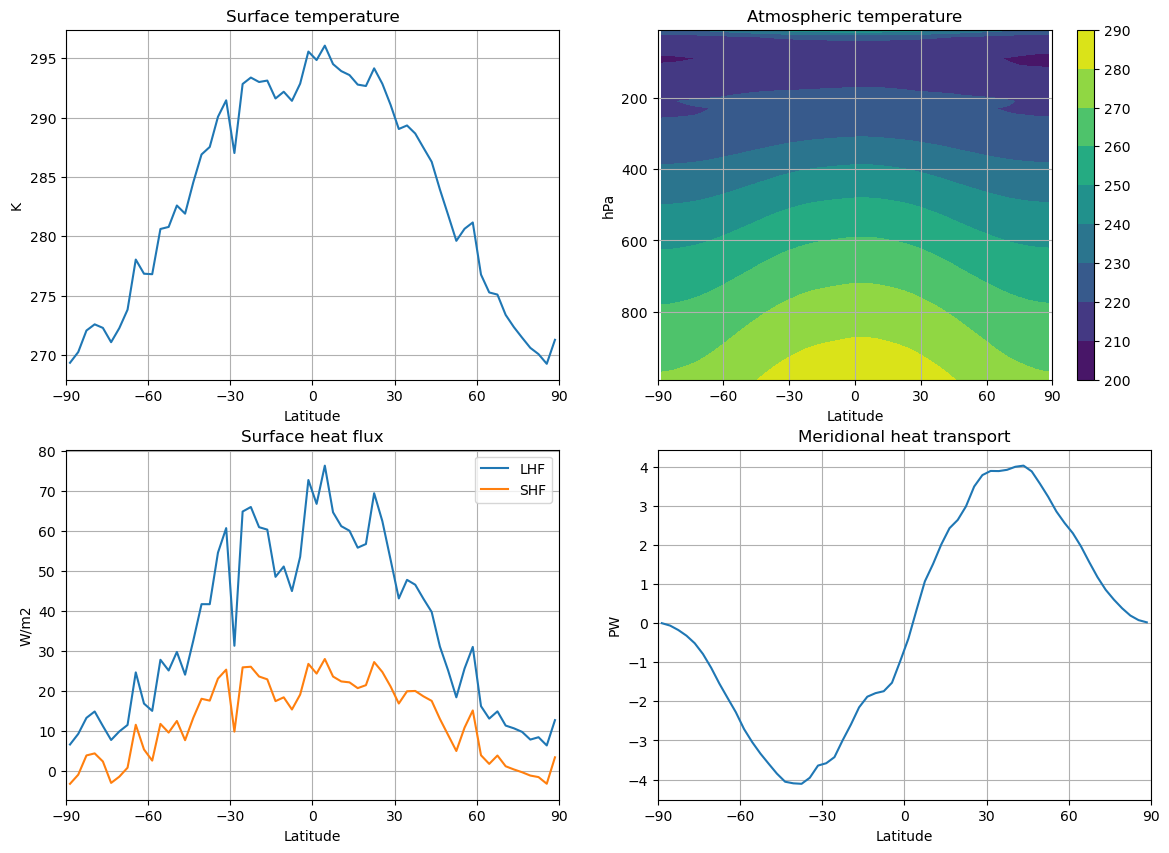

In [13]:
fig, ax = plt.subplots(2,2,figsize=(14,10))
ax[0,0].plot(model.lat, model.timeave['Ts'])
field = (model.timeave['Tatm']).transpose()
cax = ax[0,1].contourf(model.lat, model.lev, field)
ax[1,0].plot(model.lat, model.timeave['LHF'], label='LHF')
ax[1,0].plot(model.lat, model.timeave['SHF'], label='SHF')
ax[1,0].legend()
Rtoa = np.squeeze(model.timeave['ASR'] - model.timeave['OLR'])
ax[1,1].plot(model.lat, inferred_heat_transport(Rtoa, model.lat))
make_nice_plot(fig,ax,cax)

###  Reducing the evaporation efficiency

Just need to clone our model, and modify $C_D$ in the latent heat flux subprocess.

In [14]:
model2 = climlab.process_like(model)
model2.subprocess['LHF'].Cd *= 0.5
model2.integrate_years(4.)
model2.integrate_years(1.)

Integrating for 1460 steps, 1460.9688 days, or 4.0 years.
Total elapsed time is 8.994031905404139 years.
Integrating for 365 steps, 365.2422 days, or 1.0 years.
Total elapsed time is 9.993368783782378 years.


The global mean surface temperature anomaly is 0.84 K


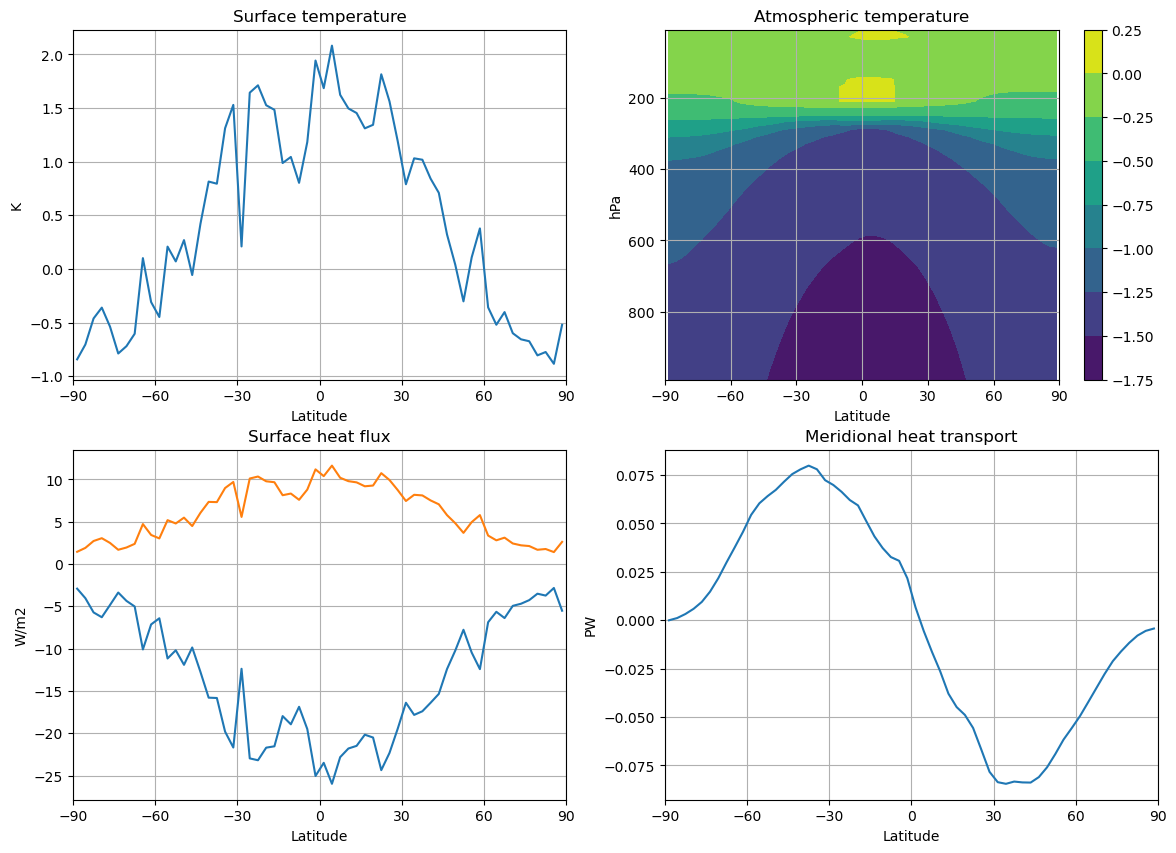

In [15]:
fig, ax = plt.subplots(2,2,figsize=(14,10))
ax[0,0].plot(model.lat, model2.timeave['Ts'] - model.timeave['Ts'])
field = (model2.timeave['Tatm'] - model.timeave['Tatm']).transpose()
cax = ax[0,1].contourf(model.lat, model.lev, field)
for field in ['LHF','SHF']:
    ax[1,0].plot(model2.lat, model2.timeave[field] - model.timeave[field], label=field)
Rtoa = np.squeeze(model.timeave['ASR'] - model.timeave['OLR'])
Rtoa2 = np.squeeze(model2.timeave['ASR'] - model2.timeave['OLR'])
ax[1,1].plot(model.lat, inferred_heat_transport(Rtoa2-Rtoa, model.lat))
make_nice_plot(fig,ax,cax)
dT = np.average(model2.timeave['Ts'] - model.timeave['Ts'], weights=np.cos(np.deg2rad(model.lat)), axis=0)[0]
print ('The global mean surface temperature anomaly is {:.2f} K'.format(dT) )

This model predicts the following:

- The **surface temperature** warms slightly in the tropics, and cools at high latitudes
- The **atmosphere** gets colder everywhere!
- There is a substantial reduction in surface latent heat flux, especially in the tropics where it is dominant.
- There is also a substantial **increase** in sensible heat flux. This is consistent with the cooler air temperatures and warmer surface.
- Colder tropical atmosphere leads to a decrease in the poleward heat tranpsort. This helps explain the high-latitude cooling.
- Notice that the heat transport responds to the **atmopsheric** temperature gradient, which changes in the opposite direction of the **surface** temperature gradient.

Basically, this model predicts that by inhibiting evaporation in the tropics, we force the tropical surface to warm and the tropical atmosphere to cool. This cooling signal is then communicated globally by atmospheric heat transport. The result is small positive global surface temperature anomaly.

### Discussion: what is this model missing?

We could list many things, but as we will see below, two key climate components that are not included in this model are

- changes in relative humidity
- cloud feedback

We will compare this result to an analogous experiment in a GCM.

____________
<a id='section3'></a>

## 3. Reduced evaporation efficiency experiment in an aquaplanet GCM
____________


The model is the familiar CESM but in simplified "aquaplanet" setup. The surface is completely covered by a shallow slab ocean.

This model setup (with CAM4 model physics) is described in detail in this paper:

> [Rose, B. E. J., Armour, K. C., Battisti, D. S., Feldl, N., and Koll, D. D. B. (2014). The dependence of transient climate sensitivity and radiative feedbacks on the spatial pattern of ocean heat uptake. Geophys. Res. Lett., 41, doi:10.1002/2013GL058955](http://onlinelibrary.wiley.com/doi/10.1002/2013GL058955/abstract;jsessionid=D32402F77E96A1F42972A200BF6FC535.f03t01)

Here we will compare a control simulation with a perturbation simulation in which we have once again **reduced the drag coefficient by a factor of 2**.


In [16]:
# Load the climatologies from the CAM4 aquaplanet runs
datapath = "http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/"
ctrl = xr.open_dataset(datapath + "QAqu_ctrl/clim/QAqu_ctrl.cam.h0.clim.nc").mean(dim='time')
halfEvap = xr.open_dataset(datapath + "QAqu_halfEvap/clim/QAqu_halfEvap.cam.h0.clim.nc").mean(dim='time')

In [17]:
lat = ctrl.lat
lon = ctrl.lon
lev = ctrl.lev

In [18]:
TS_anom = halfEvap.TS - ctrl.TS
Tatm_anom = halfEvap['T'] - ctrl['T']

### Temperature anomalies

The global mean surface temperature anomaly is 4.94 K.


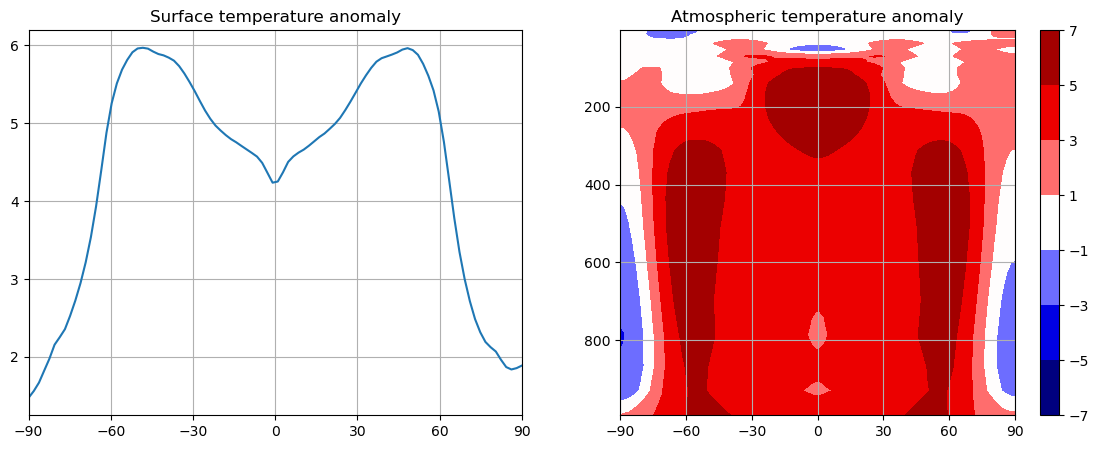

In [19]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,5))
ax1.plot(lat, TS_anom.mean(dim='lon')); ax1.set_title('Surface temperature anomaly')
cax2 = ax2.contourf(lat, lev, Tatm_anom.mean(dim='lon'), levels=np.arange(-7, 8., 2.), cmap='seismic')
ax2.invert_yaxis(); fig.colorbar(cax2,ax=ax2); ax2.set_title('Atmospheric temperature anomaly');
for ax in (ax1, ax2):
    ax.set_xlim(-90,90); ax.set_xticks(ticks); ax.grid();
    
print ('The global mean surface temperature anomaly is %0.2f K.' %((TS_anom*ctrl.gw).mean(dim=('lat','lon'))/ctrl.gw.mean(dim='lat')))

In this model, reducing the evaporation efficiency leads to a **much warmer climate**.  The largest warming occurs in mid-latitudes. The warming is **not** limited to the surface but in fact extends deeply through the troposphere.

Both the spatial pattern and the magnitude of the warming are completely different than what our much simpler model predicted.

Why?

### Compute all the terms in the TOA and surface energy and water budget anomalies


In [20]:
energy_budget = {}
for name, run in zip(['ctrl','halfEvap'],[ctrl,halfEvap]):
    budget = xr.Dataset()
    # TOA radiation
    budget['OLR'] = run.FLNT
    budget['OLR_clr'] = run.FLNTC
    budget['ASR'] = run.FSNT
    budget['ASR_clr'] = run.FSNTC
    budget['Rtoa'] = budget.ASR - budget.OLR  # net downwelling radiation
    #  surface fluxes  (all positive UP)
    budget['LHF'] = run.LHFLX
    budget['SHF'] = run.SHFLX
    budget['LWsfc'] = run.FLNS
    budget['LWsfc_clr'] = run.FLNSC
    budget['SWsfc'] = -run.FSNS
    budget['SWsfc_clr'] = -run.FSNSC
    budget['SnowFlux'] = ((run.PRECSC+run.PRECSL)
                           *const.rho_w*const.Lhfus)
    # net upward radiation from surface
    budget['SfcNetRad'] = budget['LWsfc'] + budget['SWsfc']  
    budget['SfcNetRad_clr'] = budget['LWsfc_clr'] + budget['SWsfc_clr']  
    # net upward surface heat flux
    budget['SfcNet'] = (budget['SfcNetRad'] + budget['LHF'] + 
                     budget['SHF'] + budget['SnowFlux'])
    # net heat flux in to atmosphere
    budget['Fatmin'] = budget['Rtoa'] + budget['SfcNet']  
    #  hydrological cycle
    budget['Evap'] = run['QFLX']  # kg/m2/s or mm/s
    budget['Precip'] = (run['PRECC']+run['PRECL'][:])*const.rho_w  # kg/m2/s or mm/s
    budget['EminusP'] = budget.Evap - budget.Precip  # kg/m2/s or mm/s
    energy_budget[name] = budget

In [21]:
#   Here we take advantage of xarray!
#   We can simply subtract the two xarray.Dataset objects 
#   to get anomalies for every term
#   And also take the zonal averages for all anomaly fields in one line of code
anom = energy_budget['halfEvap'] - energy_budget['ctrl']
zonanom = anom.mean(dim='lon')

### Energy budget anomalies at TOA and surface

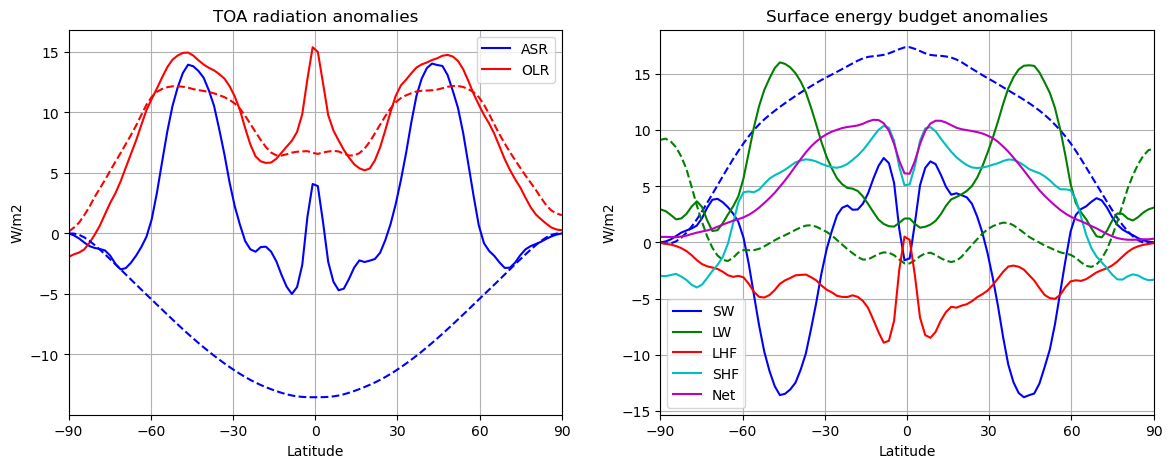

In [22]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,5))
ax1.plot(lat, zonanom.ASR, color='b', label='ASR')
ax1.plot(lat, zonanom.OLR, color='r', label='OLR')
ax1.plot(lat, zonanom.ASR_clr, color='b', linestyle='--')
ax1.plot(lat, zonanom.OLR_clr, color='r', linestyle='--')
ax1.set_title('TOA radiation anomalies')
    
ax2.plot(lat, zonanom.SWsfc, color='b', label='SW')
ax2.plot(lat, zonanom.SWsfc_clr, color='b', linestyle='--')
ax2.plot(lat, zonanom.LWsfc, color='g', label='LW')
ax2.plot(lat, zonanom.LWsfc_clr, color='g', linestyle='--')
ax2.plot(lat, zonanom.LHF, color='r', label='LHF')
ax2.plot(lat, zonanom.SHF, color='c', label='SHF')
ax2.plot(lat, zonanom.SfcNet, color='m', label='Net')
ax2.set_title('Surface energy budget anomalies')

for ax in [ax1, ax2]:
    ax.set_ylabel('W/m2'); ax.set_xlabel('Latitude')
    ax.set_xlim(-90,90); ax.set_xticks(ticks);
    ax.legend(); ax.grid();

Dashed lines are **clear-sky** radiation anomalies.

Looking at the TOA budget:

- Reducing evaporation efficiency leads to very large increase in ASR, especially in mid-latitudes
- This increase is almost entirely due to clouds!
- Accompanied by a (mostly) clear-sky OLR increase, consistent with the warmer temperatures.

This is very suggestive of an important role for **low-level cloud changes**. Why?

From the **surface budget**:

- Notice that the **decrease in evaporation is much weaker** than we found in the simple model.
- Here, the decreased evaporation **efficiency** is competing against the **warmer temperatures** which tend to strongly increase evaporation, all else being equal.
- The surface (ocean) gains a lot of excess heat by solar radiation.
- As noted from the TOA budget, this is **due to changes in cloudiness**.
- The clear-sky SW anomaly is actually positive, consistent with a warmer, moister atmosphere (but this effect is small).
- The LW anomaly is positive, indicating increased radiative cooling of the surface.
- This is also largely a cloud effect, and consistent with a **decrease in low-level cloudiness**. [Why?]
- As in the simple model, there is an **increase in the sensible heat flux** (though weaker).
- According to bulk formula, should be driven by one or both of
    - increased wind speed
    - increased air-sea temperature difference

###  Vertical structure of relative humidity and cloud changes

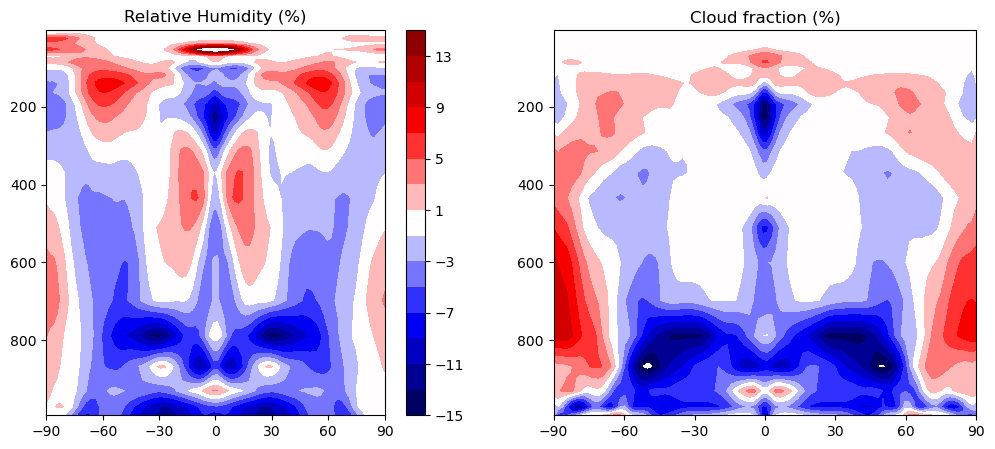

In [23]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
RH = (halfEvap.RELHUM - ctrl.RELHUM).mean(dim='lon'); CLOUD = (halfEvap.CLOUD - ctrl.CLOUD).mean(dim='lon')
contours = np.arange(-15, 16., 2.)
cax1 = ax1.contourf(lat, lev, RH, levels=contours, cmap='seismic'); fig.colorbar(cax1, ax=ax1); ax1.set_title('Relative Humidity (%)')
cax2 = ax2.contourf(lat, lev, 100*CLOUD, levels=contours, cmap='seismic'); ax2.set_title('Cloud fraction (%)')
for ax in [ax1, ax2]:
    ax.invert_yaxis(); ax.set_xlim(-90,90); ax.set_xticks(ticks);

###  Meridional heat transport anomalies


In [24]:
HT = {}
HT['total'] = inferred_heat_transport(anom.Rtoa.mean(dim='lon'), lat)
HT['atm'] = inferred_heat_transport(anom.Fatmin.mean(dim='lon'), lat)
HT['latent'] = inferred_heat_transport(anom.EminusP.mean(dim='lon') * const.Lhvap, lat)
HT['dse'] = HT['atm'] - HT['latent']

Text(0.5, 0, 'Latitude')

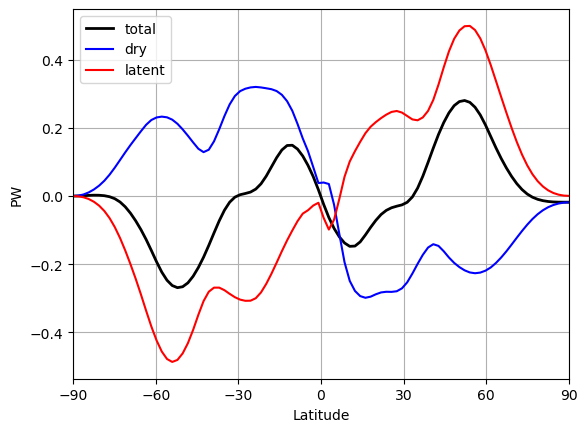

In [25]:
fig, ax = plt.subplots()
ax.plot(lat, HT['atm'], 'k-', label='total', linewidth=2)
ax.plot(lat, HT['dse'], 'b', label='dry')
ax.plot(lat, HT['latent'], 'r', label='latent')
ax.set_xlim(-90,90); ax.set_xticks(ticks); ax.grid()
ax.legend(loc='upper left'); ax.set_ylabel('PW'); ax.set_xlabel('Latitude')

____________
<a id='section4'></a>

## 4. Conclusion
____________



We have forced a climate change NOT by adding any kind of radiative forcing, but just by changing the efficiency of evaporation at the sea surface.

The climate system then find a new equilibrium in which the radiative fluxes, surface temperature, air-sea temperature difference, boundary layer relative humidity, and wind speeds all change simultaneously. 

Reasoning our way through such a problem from first principles in practically impossible. This is particularly true because in this example, the dominant driver of the climate change is an increase in SW absorption due to a substantial decrease in low-level clouds across the subtropics and mid-latitudes.

A comprehensive theory to explain these cloud changes does not yet exist. **Understanding changes in low-level cloudiness under climate change is enormously important** -- because these clouds, which have an unambiguous cooling effect, are a key determinant of climate sensitivity. There is lots of work left to do.

Water is intimately involved in just about every aspect of the planetary energy budget. Here we have highlighted the role of water in:

- Cooling of the surface by evaporation
- Water vapor greenhouse effect
- Poleward latent heat transport
- Cloud formation

____________

## Credits

This notebook is part of The Climate Laboratory, an open-source textbook developed and maintained by [Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany. It has been modified by [Nicole Feldl](http://nicolefeldl.com), UC Santa Cruz.

It is licensed for free and open consumption under the
[Creative Commons Attribution 4.0 International (CC BY 4.0)](https://creativecommons.org/licenses/by/4.0/) license.

Development of these notes and the [climlab software](https://github.com/brian-rose/climlab) is partially supported by the National Science Foundation under award AGS-1455071 to Brian Rose. Any opinions, findings, conclusions or recommendations expressed here are mine and do not necessarily reflect the views of the National Science Foundation.
____________